# Pretraining CNN encoder on a regression problem.

Idea: start with pretraining the CNN (and, additionally, work with the dataset of pictures). Then, when Decoder is added (probably LSTM), we can first train the decoder with fixed encoder weights, and then finetune Decoder-Encoder together. Kaggle links

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision.transforms import Pad, Resize

from tqdm import tqdm
import imageio
import gc

from sklearn.model_selection import train_test_split

## Scaling pictures

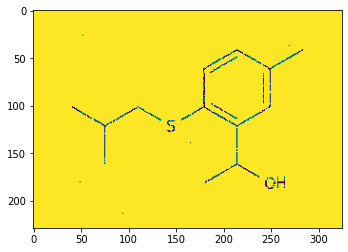

255


In [92]:
im = imageio.imread('original_data/train/0/0/0/000011a64c74.png')
plt.imshow(im)
plt.show()
print(im[2,5])

In [93]:
im = torch.Tensor(im) / 255.
im

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [94]:
im.shape

torch.Size([229, 325])

In [101]:
scaler = Resize(size=(150,300))

In [102]:
im1 = scaler(im.unsqueeze(0))
print(im1.shape)

torch.Size([1, 150, 300])


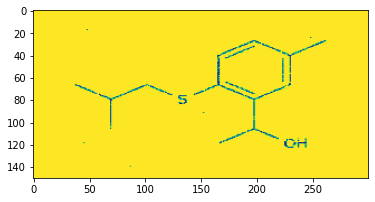

In [103]:
plt.imshow(im1[0])

## Analyze precomputed number of atoms

After first doing some computations, we analyze the results and prepare the dataset for training the CNN.

In [2]:
a = np.load('data/pretrain1/atom_counts.npy')
print(a.shape)
a

(2424186, 100)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [4]:
b = a.max(axis=0)
print(b.shape)
b

(100,)


array([ 0,  0,  0,  0,  0,  1, 72,  8, 14,  6,  0,  0,  0,  0,  2,  2,  4,
        5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int16)

We only need those atoms which are present in the dataset. Those which are rarely encountered can be easily omitted. The presented data was calculated only with the starting 10 000 pictures from the dataset. We can consider it to be representative, but not full. Ultimately, I believe that all zeros can be ignored.

In [5]:
np.argwhere(b > 0)

array([[ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [14],
       [15],
       [16],
       [17],
       [35],
       [53]])

These indices actually represent atomic numbers of the elements present in the dataset. Knowing this we can modify the existing "compute_number_of_atoms.py" file.

In [13]:
c = np.argwhere(b > 0)[:,0]
print(c.shape)
c

(11,)


array([ 5,  6,  7,  8,  9, 14, 15, 16, 17, 35, 53])

In [15]:
c[:-1]

array([ 5,  6,  7,  8,  9, 14, 15, 16, 17, 35])

## Prepare dataset for use with CNN

In [2]:
def load_pic(image_id, is_train=True):
    _ = 'train' if is_train else 'test'
    directory = 'original_data/{}/{}/{}/{}/'.format(_, image_id[0], image_id[1], image_id[2])
    return torch.Tensor(imageio.imread(directory + image_id + '.png') )

In [3]:
class PretrainRegressionDataset(torch.utils.data.Dataset):
    def __init__(self, file, y_file, x_size=256, y_size=256):
        self.data = pd.read_csv(file)
        #self.y = np.load(y_file) / 255.
        self.y = torch.tensor(np.load(y_file), dtype=torch.float32)
        self.y.to(device)
        self.x_size = x_size
        self.y_size = y_size
        self.resize = Resize(size=(x_size,y_size))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        pic = load_pic(self.data['image_id'][index]).unsqueeze(0) # C=1 channel
        pic = self.resize(pic) / 255.
        # y = torch.tensor(y[index], dtype=torch.float32) # used to be smth like this
        y = self.y[index]
        return pic, y

In [4]:
dataset = PretrainRegressionDataset('data/pretrain2/data_train_small.csv',
                                    'data/pretrain2/atom_counts_train_small.npy',
                                     x_size=cfg['x_size'], y_size=cfg['y_size'])

count = 0
for elem in dataset:
    if count > 5: break
    print(elem[0].shape)
    print(elem)
    count += 1

del dataset

NameError: name 'cfg' is not defined

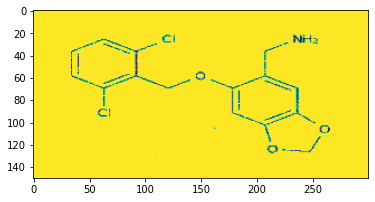

In [350]:
plt.imshow(elem[0][0])

## Train / test split

In [19]:
LENGTH = 1000000

In [20]:
data = pd.read_csv('original_data/train_labels.csv')[:LENGTH]
data.shape

(1000000, 2)

In [24]:
data_train, data_test, atom_counts_train, atom_counts_test = \
    train_test_split(data, np.load('data/pretrain2/atom_counts.npy'), test_size=0.2, random_state=35)

In [25]:
data_train

,image_id,InChI
175569,1281bed2ee3a,InChI=1S/C6H9BrN2O2/c1-3-4(7)5(10)9(2)6(11)8-3...
834111,580775bd2a6b,"InChI=1S/C14H22N2O4S/c1-9(2)8-21(18,19)12-6-16..."
973026,66bb94ff2079,"InChI=1S/C13H21N3/c1-16-9-7-13(11-14,8-10-16)1..."
501799,34f40aa88d1c,InChI=1S/C21H31N7O/c1-14(29)24-17-8-10-27(12-1...
650344,449f6fdf7a6d,InChI=1S/C18H19F3N4O3/c1-11-23-24-16(28-11)14(...
...,...,...
56300,05e95868fdac,InChI=1S/C9H13N3S/c1-7-6-13-9-5-11-8(12(7)9)3-...
179233,12e5753b227e,InChI=1S/C12H15N3O3/c1-7-11(17)10(9(6-16)4-13-...
41911,0466037098cd,InChI=1S/C16H23N3O9/c1-6-9(20)7(11(22)13(24)10...
378127,27e76db21e27,InChI=1S/C12H20N2OS/c1-5-7-14(9(3)4)12-13-10(6...


In [26]:
data_test

,image_id,InChI
161130,10fa9e6bed97,InChI=1S/C11H14FN5O2S/c1-13-4-5-17-8-9(6-15-17...
690797,48e2b59ac565,InChI=1S/C12H16N6OS/c1-9-14-15-10(20-9)11(19)1...
298755,1f791731b1b5,InChI=1S/C8H14ClN3O/c1-6-8(9)7(12(2)11-6)5-13-...
105888,0b2f019dcc7f,InChI=1S/C15H20N2OS/c1-10-8-17(9-11(2)19-10)15...
641095,43a7ac609965,InChI=1S/C16H25ClN2/c1-2-19(15-9-4-3-5-10-15)1...
...,...,...
336556,237acce8112e,InChI=1S/C19H17ClN4/c20-15-3-1-4-16(10-15)24-1...
87642,093f87ef2ea4,InChI=1S/C9H9FO/c1-2-7-3-4-8(6-11)9(10)5-7/h3-...
159107,10c374e68e6d,InChI=1S/C14H12BrF3N2O/c1-8-5-10(15)3-4-11(8)2...
573707,3c88dd90a47a,InChI=1S/C18H24N6O2/c1-13-4-6-19-17(22-13)26-1...


In [27]:
data_train.to_csv('data/pretrain2/data_train.csv')
data_test.to_csv( 'data/pretrain2/data_test.csv')
del data_train
del data_test
del data
np.save('data/pretrain2/atom_counts_train.npy', atom_counts_train)
np.save('data/pretrain2/atom_counts_test.npy', atom_counts_test)
del atom_counts_train
del atom_counts_test

#### Small dataset

Same for the small dataset.

In [302]:
LENGTH = 10000
data = pd.read_csv('original_data/train_labels.csv')[:LENGTH]
data_train, data_test, atom_counts_train, atom_counts_test = \
    train_test_split(data, np.load('data/pretrain2/atom_counts.npy')[:LENGTH,:],test_size=0.2,random_state=35)
data_train.to_csv('data/pretrain2/data_train_small.csv')
data_test.to_csv( 'data/pretrain2/data_test_small.csv')
del data_train
del data_test
del data
np.save('data/pretrain2/atom_counts_train_small.npy', atom_counts_train)
np.save('data/pretrain2/atom_counts_test_small.npy', atom_counts_test)
del atom_counts_train
del atom_counts_test

## Defining Convolutional Neural Network

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in1, out1, in2, out2, st1=1, st2=1, dropout=0.2):
        super(ConvBlock, self).__init__()
        # nn.Conv2D(in_channels, out_channels, kernel_size=(,), stride)
        self.conv1 = nn.Conv2d(in1, out1, kernel_size=(2,2), stride=st1)
        self.conv2 = nn.Conv2d(in2, out2, kernel_size=(2,2), stride=st2)
        self.relu  = nn.ReLU()
        self.pool  = nn.MaxPool2d(kernel_size=(2,2))
        self.bn    = nn.BatchNorm2d(out2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

In [6]:
class CNNEncoder(nn.Module):
    def __init__(self, config):
        super(CNNEncoder, self).__init__()
        n_ch = config['n_channels']
        i_ch = config['input_channels']
        f1_len = config['fc_intermediate_len']
        f2_len = config['output_channels'] # len(y)
        self.conv_block_1 = ConvBlock(in1=i_ch, out1=n_ch, in2=n_ch, out2=n_ch, st1=2)
        self.conv_block_2 = ConvBlock(in1=n_ch, out1=n_ch, in2=n_ch, out2=n_ch)
        self.fc1 = nn.Linear(n_ch * 612, f1_len) # FIXME dimensions
        self.fc2 = nn.Linear(f1_len, f2_len)
        self.relu = nn.ReLU()
        self.dropout=nn.Dropout(config['dropout'])
    
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        #print('\n', x.shape, '\n', sep='')
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        return x

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
def calc_loss(cnn, data_loader, loss_type='mse'):
    if loss_type =='mse': Loss = nn.MSELoss()
    loss = 0.0
    cnn.eval()
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            predictions = cnn(x_batch)
            loss += Loss(predictions, y_batch).item()
    return loss

In [9]:
def train_epoch(data_loader, cnn, optimizer): #, criterion):
    criterion = nn.MSELoss()
    running_loss = 0.0
    for x_batch, y_batch in tqdm(data_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = cnn(x_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        running_loss += loss.item()
        #prev_param = list(cnn.parameters())[15].data.clone()
        optimizer.step()
        #curr_param = list(cnn.parameters())[15].data.clone()
        """
        if torch.all(torch.eq(prev_param, curr_param)):
            print('\nERROR:\n')
            print(prev_param)
            print(curr_param)
            break
        else:
            print('ok')
            print(prev_param)
            print(curr_param)
            break
        """
    print('running_loss after epoch is', running_loss)

In [21]:
def train_model(dataset_train, dataset_test, cnn, n_epochs, batch_size):
    data_train_loader = torch.utils.data.DataLoader(dataset_train, batch_size,
                                                   num_workers=6, persistent_workers=False,pin_memory=True)
    data_test_loader  = torch.utils.data.DataLoader(dataset_test, batch_size, num_workers=2)
    #criterion = nn.MSELoss()
    #optimizer = torch.optim.SGD(cnn.parameters(), lr=0.9)#, momentum=0.9, nesterov=True)
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.01)
    for i in range(n_epochs):
        print('Starting epoch {}'.format(i))
        cnn.train()
        train_epoch(data_train_loader, cnn, optimizer)#, criterion)
        train_loss = 'dummy'#calc_loss(cnn, data_train_loader)
        test_loss = 'dummy'#calc_loss(cnn, data_test_loader)
        print('Train loss:\t', train_loss)
        print('Test loss:\t',  test_loss)

#### Minor tests

In [137]:
with torch.no_grad():
    Loss = nn.MSELoss()
    target = torch.randn(3, 5)
    input_ = torch.randn(3, 5)
    out = Loss(input_, target)
del Loss
del target
del input_
out

tensor(2.4505)

In [139]:
out.grad is None

True

In [140]:
out.item()

2.450530529022217

In [265]:
out.clone()

tensor(2.4505)

## Config

In [13]:
cfg = dict()
cfg['n_channels'] = 50
cfg['input_channels'] = 1
cfg['output_channels'] = 11 # 100
cfg['dropout'] = 0.2
cfg['fc_intermediate_len'] = 200 # ? 128
cfg['x_size'] = 150 # ? such order of dims
cfg['y_size'] = 300 # ? such order of dims

#### Initializing datasets

In [14]:
"""
dataset_train = PretrainRegressionDataset('data/pretrain2/data_train.csv',
                                          'data/pretrain2/atom_counts_train.npy',
                                           x_size=cfg['x_size'], y_size=cfg['y_size'])
dataset_test = PretrainRegressionDataset('data/pretrain2/data_test.csv',
                                          'data/pretrain2/atom_counts_test.npy',
                                          x_size=cfg['x_size'], y_size=cfg['y_size'])
"""
dataset_train = PretrainRegressionDataset('data/pretrain2/data_train_small.csv',
                                          'data/pretrain2/atom_counts_train_small.npy',
                                           x_size=cfg['x_size'], y_size=cfg['y_size'])
dataset_test = PretrainRegressionDataset('data/pretrain2/data_test_small.csv',
                                          'data/pretrain2/atom_counts_test_small.npy',
                                          x_size=cfg['x_size'], y_size=cfg['y_size'])

In [23]:
cnn = CNNEncoder(cfg)

In [24]:
gc.collect()
torch.cuda.empty_cache()

In [25]:
cnn.to(device)

CNNEncoder(
  (conv_block_1): ConvBlock(
    (conv1): Conv2d(1, 50, kernel_size=(2, 2), stride=(2, 2))
    (conv2): Conv2d(50, 50, kernel_size=(2, 2), stride=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (bn): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block_2): ConvBlock(
    (conv1): Conv2d(50, 50, kernel_size=(2, 2), stride=(1, 1))
    (conv2): Conv2d(50, 50, kernel_size=(2, 2), stride=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (bn): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=30600, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=11, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [26]:
%%time
train_model(dataset_train, dataset_test, cnn, n_epochs=5, batch_size=50)

  0%|          | 0/160 [00:00<?, ?it/s]

Starting epoch 0


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 45243.7733669281
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 1


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 1487.5518848896027
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 2


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 1474.3192930221558
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 3


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 1435.3758068084717
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 4


100%|██████████| 160/160 [00:20<00:00,  7.66it/s]

running_loss after epoch is 1436.4188497066498
Train loss:	 dummy
Test loss:	 dummy
CPU times: user 1min 18s, sys: 27.6 s, total: 1min 46s
Wall time: 1min 44s


In [33]:
torch.save(cnn.state_dict(), 'data/pretrain2/cnn1.model')

In [46]:
cnn = CNNEncoder(cfg)
cnn.load_state_dict(torch.load('data/pretrain2/cnn1.model'))

<All keys matched successfully>

In [47]:
gc.collect()
torch.cuda.empty_cache()

In [48]:
cnn.to(device)

CNNEncoder(
  (conv_block_1): ConvBlock(
    (conv1): Conv2d(1, 50, kernel_size=(2, 2), stride=(2, 2))
    (conv2): Conv2d(50, 50, kernel_size=(2, 2), stride=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (bn): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block_2): ConvBlock(
    (conv1): Conv2d(50, 50, kernel_size=(2, 2), stride=(1, 1))
    (conv2): Conv2d(50, 50, kernel_size=(2, 2), stride=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (bn): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=30600, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=11, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [49]:
%%time
train_model_4(dataset_train, dataset_test, cnn, n_epochs=20, batch_size=50)

  0%|          | 0/160 [00:00<?, ?it/s]

Starting epoch 0


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 817.8659634590149
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 1


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 839.4639675617218
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 2


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 860.1921463012695
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 3


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 813.1896641254425
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 4


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 839.1341006755829
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 5


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 815.0525312423706
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 6


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 801.459254026413
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 7


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 805.300062417984
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 8


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 801.017550945282
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 9


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 817.7927849292755
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 10


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 807.0460455417633
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 11


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 823.4693551063538
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 12


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 817.4551486968994
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 13


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 796.8217666149139
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 14


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 849.1962591409683
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 15


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 838.9715287685394
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 16


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 805.5852496623993
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 17


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 809.9471213817596
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 18


  0%|          | 0/160 [00:00<?, ?it/s]

running_loss after epoch is 803.988508939743
Train loss:	 dummy
Test loss:	 dummy
Starting epoch 19


100%|██████████| 160/160 [00:20<00:00,  7.92it/s]

running_loss after epoch is 837.1514089107513
Train loss:	 dummy
Test loss:	 dummy
CPU times: user 5min 4s, sys: 1min 47s, total: 6min 52s
Wall time: 6min 44s


In [45]:
def train_model_4(dataset_train, dataset_test, cnn, n_epochs, batch_size):
    data_train_loader = torch.utils.data.DataLoader(dataset_train, batch_size,
                                                   num_workers=6, persistent_workers=False,pin_memory=True)
    data_test_loader  = torch.utils.data.DataLoader(dataset_test, batch_size, num_workers=2)
    #criterion = nn.MSELoss()
    #optimizer = torch.optim.SGD(cnn.parameters(), lr=0.9)#, momentum=0.9, nesterov=True)
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.000001)
    for i in range(n_epochs):
        print('Starting epoch {}'.format(i))
        cnn.train()
        train_epoch(data_train_loader, cnn, optimizer)#, criterion)
        train_loss = 'dummy'#calc_loss(cnn, data_train_loader)
        test_loss = 'dummy'#calc_loss(cnn, data_test_loader)
        print('Train loss:\t', train_loss)
        print('Test loss:\t',  test_loss)

In [258]:
a=list(cnn.parameters())
print(len(a))

16


In [259]:
a[15]

Parameter containing:
tensor([-1.6010e+08, -1.6010e+08, -1.6010e+08, -1.6010e+08, -1.6010e+08,
        -1.6010e+08, -1.6010e+08, -1.6010e+08, -1.6010e+08, -1.6010e+08,
        -1.6010e+08], device='cuda:0', requires_grad=True)

In [260]:
a[15].grad

tensor([0.0160, 0.0104, 0.0450, 0.0106, 0.0207, 0.0180, 0.0353, 0.0211, 0.0088,
        0.0190, 0.0212], device='cuda:0')

In [263]:
a[1].data

tensor([-4.8014e-01,  1.5826e+08, -9.9223e+07,  1.6010e+08,  1.6010e+08,
        -1.6010e+08,  1.2251e+08, -1.6010e+08, -1.6010e+08,  1.6008e+08,
         1.6010e+08,  1.6000e+08, -4.3445e-01,  1.5483e+08,  1.6010e+08,
        -1.5551e+08,  1.6006e+08,  1.6010e+08, -2.0903e-01, -1.5083e+08,
        -1.6009e+08,  1.6010e+08,  1.6009e+08,  1.6010e+08,  1.6010e+08,
        -1.6006e+08, -6.0362e-02,  1.6010e+08,  1.6010e+08,  1.6010e+08,
        -1.6010e+08,  1.6009e+08, -1.6010e+08,  1.6010e+08, -1.6009e+08,
        -1.6009e+08, -1.6010e+08, -1.6010e+08,  1.6010e+08, -1.6009e+08,
         1.6010e+08, -1.6009e+08, -1.6010e+08, -1.5792e+08,  1.6010e+08,
        -1.6010e+08,  1.6010e+08, -1.6009e+08,  1.6010e+08, -1.6010e+08],
       device='cuda:0')